In [1]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms, models

## Функция извлечения букв из изображения с паспортом
Поля сверху вниз, буквы в полях слева направо

In [63]:
def passport_preprocessing(img):
    img = imutils.resize(img, height=1000)
    orig = img.copy()
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # ОБРАБОТКА, ВЫДЕЛЕНИЕ КОНТУРОВ (ТЕКСТОВЫЕ ПОЛЯ В СЛИВАЮЩУЮСЯ ЛИНИЮ)
    # конвертация в ч-б
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # задание порога для получения контуров
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # трансформация изображения с помощью фильтров
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 6))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    contours, hierarchy = cv2.findContours(morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # ВЫБОР ТЕКСТОВЫХ ПРЯМОУГОЛЬНИКОВ С ДАННЫМИ
    result = img.copy()
    text_crop = []
    for c in contours:
        box = cv2.boundingRect(c)
        x,y,w,h = box

        if 50 < w < 250 and 15 < h < 25:
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
            text_crop.append([x,y,w,h])

    text_crops = sorted(text_crop, key = lambda x: x[1], reverse=False) #сортировка рамок по оси У

    all_letters = [] #лист со всеми буквами паспорта
    for text_crop in text_crops:
        try:
            x,y,w,h = text_crop

            # ОБРАБОТКА С РАЗМЫТИЕМ (ИЗ ЭТОГО ВАРИАНТА БЕРЕМ ОБРЕЗ ДЛЯ БУКВ)
            dilated_img = cv2.dilate(gray, np.ones((3, 3), np.uint8))
            bg_img = cv2.medianBlur(dilated_img, 21)
            diff_img = 255 - cv2.absdiff(gray, bg_img)
            norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255,
                                     norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
            # Задание порога для выделения контуров Otsu's
            work_img = cv2.threshold(norm_img, 0, 255, cv2.THRESH_OTSU)[1]

            # ОБРЕЗКА ПОЛЕЙ С ТЕКСТОМ
            crop_img = work_img[y:y + h, x:x + w]
            crop_img = imutils.resize(crop_img, height=100)

            # ИЗВЛЕЧЕНИЕ БУКВ
            # Получение контуров
            contours, hierarchy = cv2.findContours(crop_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0]) #Сортировка букв по оси Х в строке

            output = crop_img.copy()
            letters = [] #список букв в слове
            letters_crop = [] #список контуров с буквами

            for c in contours:
                box = cv2.boundingRect(c)
                x,y,w,h = box
                if h > 60 and 20 < w < crop_img.shape[1] - 100:
                    cv2.rectangle(crop_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    letters_crop.append([x,y,w,h])
                    cropped_letter = output[y:y + h, x:x + w]
                    pieces = round(w / h) #на сколько букв разделить рамку с частью слова
                    if pieces > 1: #если в рамке больше одной буквы
                        M = int(cropped_letter.shape[1] // pieces) + 1 #сколько пикселей в каждой части слова
                        tiles = [cropped_letter[:, x:x + M] for x in range(0, cropped_letter.shape[1], M)]
                        for i in tiles:
                            cropped_letter = cv2.resize(i, (128, 128), interpolation=cv2.INTER_AREA)
                            letters.append(cropped_letter)                         
                    else: #если в рамке одна буква
                        cropped_letter = cv2.resize(cropped_letter, (128, 128), interpolation=cv2.INTER_AREA)
                        letters.append(cropped_letter)
            all_letters.append(letters)

        except IndexError as e:
            print(f"контуры не найдены")
    return all_letters, result

Получение списка списков букв

In [95]:
img = cv2.imread(f"/content/drive/MyDrive/Datasets/_DataForOCR_yandex_10examples/0.jpeg")
len_list, result = passport_preprocessing(img)

Показ полей, которые разпознала функция. В функции стоит ограничение на длину распознаваемой строки, для распознавания нужных полей.

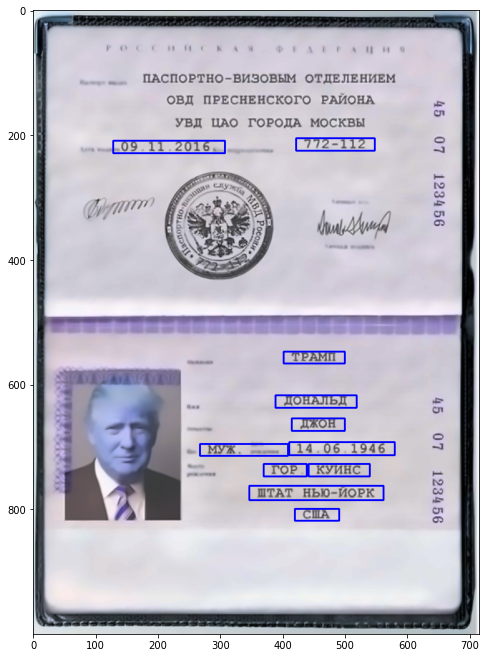

In [96]:
fig, axs = plt.subplots(figsize=(8, 12))
axs.imshow(result)
plt.show()

Распечатаем все полученные изображения с буквами по полям

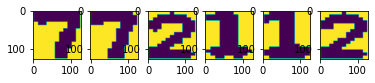

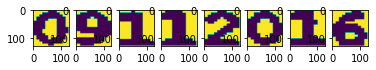

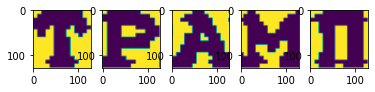

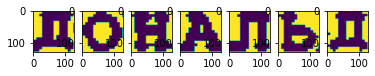

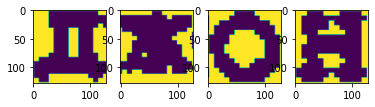

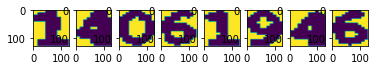

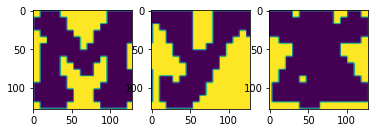

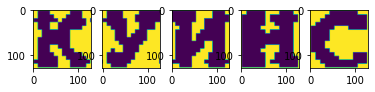

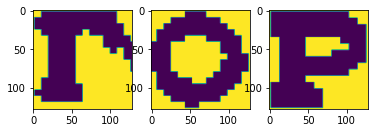

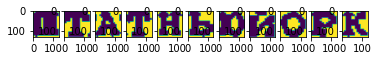

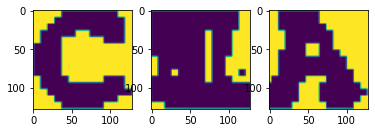

In [97]:
for i in len_list:
    f, axarr = plt.subplots(1,len(i))    
    for num, j in enumerate(i):
        axarr[num].imshow(j)

## Загрузка модели

Задание архитектуры модели

In [98]:
model = models.resnet18(pretrained=True)

# Отключения градиента для сверточных слоев
for param in model.parameters():
    param.requires_grad = False

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net = model.to(device)

Загрузка весов предобученной модели

In [99]:
net = model
net.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/font_net.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Трансформирование изображений для передачи в модель

In [100]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [101]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
           'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 
           'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 
           'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
numbers = classes[:10]

Получение предсказаний

In [ ]:
net.eval()

In [103]:
text = []
for i in len_list:
    print()
    words = []
    for j in i:
        image = transform(j)
        image = torch.unsqueeze(image, dim=0).to(device)
        pred = net(image)
        _, predicted = torch.max(pred, 1)

        print('', end = ''.join(f'{classes[predicted[0]]:5s}'))
        words.append(classes[predicted[0]])
    text.append(words)


Ж    Ж    Ж    К    У    Ж    
А    Ж    9    О    Ж    Ж    Ъ    З    
З    Ж    Х    М    Й   
Ц    А    Ж    Ж    Д    Ь    Щ    
Щ    7    А    Щ    
Т    Ж    А    Ж    1    Ж    3    Ж    
Ж    Ж    Ж    
К    Ж    Й   А    Э    
Ж    А    Ъ    
Э    С    Ж    Й   М    А    Ж    И    А    З    Й   
У    Ж    А    

Функция для определения номера поля с первой встречающейся цифровой строкой.  
Нужные нам три поля с ФИО будут через одну строку от этого поля.

In [106]:
def num_row(text):
  for num, row in enumerate(text):
    col = 0
    for j in row:
      if j in numbers:
        col += 1
    if col > 0:
      return num

In [107]:
num_row(text)

1

Результат: три строки с ФИО

In [108]:
fio = text[num_row(text)+1:num_row(text)+4]
fio = [" ".join(i) for i in fio]
fio

['З Ж Х М Й', 'Ц А Ж Ж Д Ь Щ', 'Щ 7 А Щ']